In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 27651352.57it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


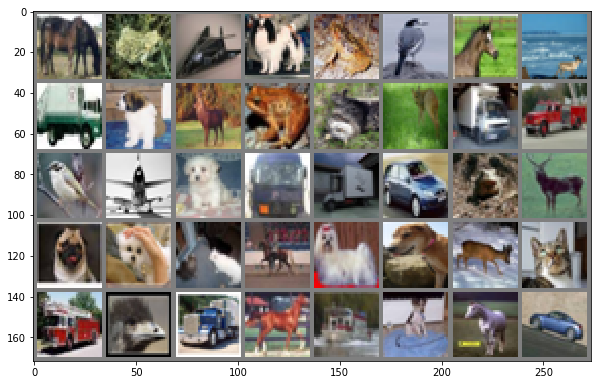

In [ ]:
def imshow(img):
    plt.figure(figsize=(10,10))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[np.random.choice(500, size=(1,40), replace=False)]))

In [ ]:
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [ ]:

import math
import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it
#from torch.optim import Optimizer
#credit - Lookahead implementation from LonePatient - https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
#credit2 - RAdam code by https://github.com/LiyuanLucasLiu/RAdam/blob/master/radam.py


class Ranger(Optimizer):
    
    def __init__(self, params, lr=1e-3, alpha=0.5, k=6, betas=(.9,0.999), eps=1e-8, weight_decay=0):
        #parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')
        
        #prep defaults and init torch.optim base
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params,defaults)
        
        #now we can get to work...
        for group in self.param_groups:
            group["step_counter"] = 0
            #print("group step counter init")
                      
        #look ahead params
        self.alpha = alpha
        self.k = k 
        
        #radam buffer for state
        self.radam_buffer = [[None,None,None] for ind in range(10)]
        
        #lookahead weights
        self.slow_weights = [[p.clone().detach() for p in group['params']]
                                for group in self.param_groups]
        
        #don't use grad for lookahead weights
        for w in it.chain(*self.slow_weights):
            w.requires_grad = False
        
    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)
       
        
    def step(self, closure=None):
        loss = None
        #note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.  
        #Uncomment if you need to use the actual closure...
        
        #if closure is not None:
            #loss = closure()
            
        #------------ radam
        for group in self.param_groups:
    
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')
    
                p_data_fp32 = p.data.float()
    
                state = self.state[p]
    
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)
    
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
    
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
    
                state['step'] += 1
                buffered = self.radam_buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size
    
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
    
                if N_sma > 5:                    
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)
    
                p.data.copy_(p_data_fp32)
        
        
        #---------------- end radam step
        
        #look ahead tracking and updating if latest batch = k
        for group,slow_weights in zip(self.param_groups,self.slow_weights):
            group['step_counter'] += 1
            if group['step_counter'] % self.k != 0:
                continue
            for p,q in zip(group['params'],slow_weights):
                if p.grad is None:
                    continue
                q.data.add_(self.alpha,p.data - q.data)
                p.data.copy_(q.data)
            
        
            
        return loss



In [ ]:
import copy

In [ ]:
net = torchvision.models.resnet18(pretrained=False)
# for param in net.parameters():
#     param.requires_grad = False
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, len(classes))

In [ ]:
net1 = copy.deepcopy(net)
net1.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = RAdam(net1.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
def validation(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.cuda()
          labels = labels.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return 100 * correct / total

In [ ]:
for epoch in range(20):  # loop over the dataset multiple times
    loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    val_score = validation(net1)
    print('[%d, %5d] loss: %.3f validation score: %.2f' %
          (epoch + 1, i + 1, loss, val_score))

print('Finished Training')

[1,    98] loss: 1.412 validation score: 48.41
[2,    98] loss: 1.164 validation score: 54.42
[3,    98] loss: 0.986 validation score: 58.31
[4,    98] loss: 0.962 validation score: 60.71
[5,    98] loss: 0.751 validation score: 61.86
[6,    98] loss: 0.724 validation score: 62.20
[7,    98] loss: 0.554 validation score: 62.80
[8,    98] loss: 0.513 validation score: 64.25
[9,    98] loss: 0.378 validation score: 63.32
[10,    98] loss: 0.377 validation score: 64.73


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net1(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 43 %
Accuracy of   car : 32 %
Accuracy of  bird : 17 %
Accuracy of   cat : 12 %
Accuracy of  deer : 32 %
Accuracy of   dog : 29 %
Accuracy of  frog : 43 %
Accuracy of horse : 32 %
Accuracy of  ship : 45 %
Accuracy of truck : 31 %


In [ ]:
import random

In [ ]:
loc = 0
scale=0.001
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
def mutate_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data = m.weight.data + normal.rsample(m.weight.size()).cuda()

In [ ]:
def crossover(model1, model2):
  for name, weights1, _, weights2 in zip(model1.named_parameters(), model2.named_parameters()):
    

In [ ]:
net2.conv1.weight.data.size()

torch.Size([64, 3, 7, 7])

In [ ]:
t1 = torch.cuda.FloatTensor(10, 10).uniform_() > 0.5
layer1 = torch.cuda.FloatTensor(10, 10)
layer2 = torch.cuda.FloatTensor(10, 10)
layer_new = copy.deepcopy(layer2)
layer_new[t1] = layer1[t1]

In [ ]:
net2.layer4.keys()

AttributeError: ignored

In [ ]:
for b in net2.children():
  print(b)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:
net2 = copy.deepcopy(net)
net2.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = RAdam(net2.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
for epoch in range(20):  # loop over the dataset multiple times
  if (epoch % 5 == 0):
    #for _ in range(2):
    best_child = copy.deepcopy(net2)
    best_child.apply(mutate_weights)
    best_child_score = validation(best_child)
    for _ in range(19):
      child = copy.deepcopy(net2)
      child.apply(mutate_weights)
      child_score = validation(child)
      if child_score > best_child_score:
        best_child_score = copy.deepcopy(child_score)
        best_child = copy.deepcopy(child)
    net2 = copy.deepcopy(best_child)
    optimizer = RAdam(net2.parameters(), lr=0.001, weight_decay=0.01)
    del child
    del best_child
    print(f"best child - {best_child_score}%")
  else:
    loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net2(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
    val_score = validation(net2)
    print('[%d, %5d] loss: %.3f validation score: %.2f %%' %
          (epoch + 1, i + 1, loss, val_score))

print('Finished Training')

best child - 11.75%
[2,    98] loss: 2.264 validation score: 16.93 %
[3,    98] loss: 2.167 validation score: 23.33 %
[4,    98] loss: 1.998 validation score: 26.61 %
[5,    98] loss: 2.021 validation score: 28.04 %
best child - 28.65%
[7,    98] loss: 1.928 validation score: 29.28 %
[8,    98] loss: 1.850 validation score: 30.09 %
[9,    98] loss: 1.907 validation score: 30.46 %
[10,    98] loss: 1.944 validation score: 31.23 %
best child - 31.14%
[12,    98] loss: 1.870 validation score: 31.36 %
[13,    98] loss: 1.847 validation score: 31.48 %
[14,    98] loss: 1.940 validation score: 31.81 %
[15,    98] loss: 1.808 validation score: 31.97 %
best child - 32.26%
[17,    98] loss: 1.832 validation score: 32.23 %
[18,    98] loss: 1.831 validation score: 32.41 %
[19,    98] loss: 1.972 validation score: 32.36 %
[20,    98] loss: 1.852 validation score: 32.51 %
Finished Training


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 45 %
Accuracy of   car : 22 %
Accuracy of  bird : 25 %
Accuracy of   cat : 20 %
Accuracy of  deer : 25 %
Accuracy of   dog : 27 %
Accuracy of  frog : 41 %
Accuracy of horse : 34 %
Accuracy of  ship : 43 %
Accuracy of truck : 40 %


Accuracy of plane : 43 %
Accuracy of   car : 32 %
Accuracy of  bird : 17 %
Accuracy of   cat : 12 %
Accuracy of  deer : 32 %
Accuracy of   dog : 29 %
Accuracy of  frog : 43 %
Accuracy of horse : 32 %
Accuracy of  ship : 45 %
Accuracy of truck : 31 %

In [ ]:
!nvidia-smi

Sun Oct  6 13:59:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |    484MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  